In [4]:
import pathlib
import tensorflow as tf
import datetime

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, experimental, BatchNormalization

In [5]:
%load_ext tensorboard

In [6]:
data_dir = pathlib.Path('input/face-mask-detection/dataset')

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5098


In [31]:
batch_size = 32
img_height = 128
img_width = 128
Image_Size = (img_width, img_height)

In [32]:
train = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=69,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical")

Found 5244 files belonging to 3 classes.
Using 4196 files for training.


In [33]:
test = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=69,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical")

Found 5244 files belonging to 3 classes.
Using 1048 files for validation.


In [34]:
class_names = train.class_names
print(class_names)

['incorrect_mask', 'with_mask', 'without_mask']


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
input_shapes = (128, 128, 3)

In [37]:
model = Sequential()

model.add(experimental.preprocessing.Rescaling(
    1/255, input_shape=(input_shapes)))

model.add(Conv2D(32, (3, 3), activation=keras.activations.relu,
          input_shape=input_shapes))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation=keras.activations.relu))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=keras.activations.relu))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation=keras.activations.relu))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation=keras.activations.softmax))

In [38]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=3, mode="min")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

In [39]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        1

In [41]:
history = model.fit(train, epochs=15, validation_data=test,
                    callbacks=[early_stopping, tensorboard_callback])

Epoch 1/15


C:\Users\batuhan\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


132/132 [==============================] - 89s 654ms/step - loss: 0.4685 - accuracy: 0.8310 - precision: 0.8476 - recall: 0.8153 - val_loss: 10.8418 - val_accuracy: 0.3950 - val_precision: 0.3950 - val_recall: 0.3950
Epoch 2/15
132/132 [==============================] - 81s 618ms/step - loss: 0.2876 - accuracy: 0.8990 - precision: 0.9059 - recall: 0.8904 - val_loss: 4.7546 - val_accuracy: 0.3969 - val_precision: 0.3969 - val_recall: 0.3969
Epoch 3/15
132/132 [==============================] - 80s 602ms/step - loss: 0.2227 - accuracy: 0.9218 - precision: 0.9294 - recall: 0.9156 - val_loss: 2.0745 - val_accuracy: 0.5076 - val_precision: 0.5081 - val_recall: 0.5076
Epoch 4/15
132/132 [==============================] - 73s 557ms/step - loss: 0.1776 - accuracy: 0.9357 - precision: 0.9399 - recall: 0.9285 - val_loss: 1.1374 - val_accuracy: 0.7510 - val_precision: 0.7568 - val_recall: 0.7452
Epoch 5/15
132/132 [==============================] - 80s 607ms/step - loss: 0.1447 - accuracy: 0.9476

In [42]:
model.save('mask_detection_model.h5')

In [43]:
model = keras.models.load_model('mask_detection_model.h5')

In [44]:
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [45]:
def plot_curve(metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(metric)
    plt.show()

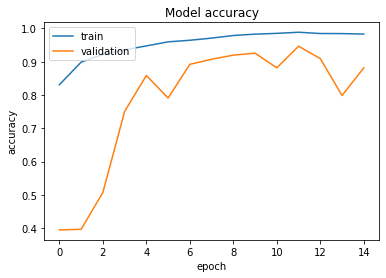

In [46]:
plot_curve('accuracy')

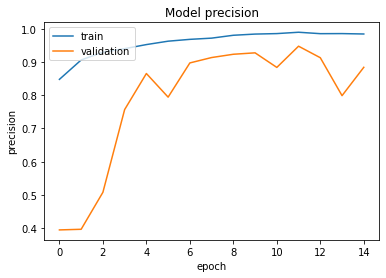

In [47]:
plot_curve('precision')

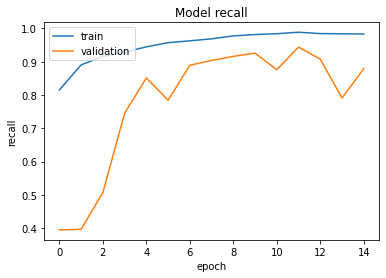

In [48]:
plot_curve('recall')

In [49]:
model.evaluate(test, return_dict=True)

C:\Users\batuhan\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 4s 120ms/step - loss: 0.3872 - accuracy: 0.8817 - precision: 0.8839 - recall: 0.8788


{'loss': 0.3872116804122925,
 'accuracy': 0.8816794157028198,
 'precision': 0.883877158164978,
 'recall': 0.8788167834281921}